<a href="https://colab.research.google.com/github/sattxnan007/automated-cyber-detection/blob/main/SOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import io
from sklearn.model_selection import train_test_split

# ==========================================
# 1. นำเข้าข้อมูล Log (ย่อมาให้มีทั้งคนปกติและบอท)
# ==========================================
log_data = """
172.17.0.1 - - [20/Feb/2026:17:25:39 +0000] "GET /vulnerabilities/sqli/ HTTP/1.1" 302 343 "http://localhost/security.php" "Mozilla/5.0 (Linux; Android 6.0; Nexus 5)"
172.17.0.1 - - [20/Feb/2026:17:25:49 +0000] "POST /login.php HTTP/1.1" 302 337 "http://localhost/login.php" "Mozilla/5.0 (Linux; Android 6.0; Nexus 5)"
172.17.0.1 - - [20/Feb/2026:17:26:00 +0000] "GET /setup.php HTTP/1.1" 200 1049 "http://localhost/setup.php" "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
172.17.0.1 - - [20/Feb/2026:17:31:09 +0000] "GET /vulnerabilities/sqli/?id=1&Submit=Submit HTTP/1.1" 200 1756 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
172.17.0.1 - - [20/Feb/2026:17:31:09 +0000] "GET /vulnerabilities/sqli/?id=1%27%20AND%209573%3D5701%20AND%20%27amTc%27%3D%27amTc&Submit=Submit HTTP/1.1" 200 1735 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
172.17.0.1 - - [20/Feb/2026:17:31:10 +0000] "GET /vulnerabilities/sqli/?id=1%22%29%20AND%202124%3D2297%23&Submit=Submit HTTP/1.1" 200 1774 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
172.17.0.1 - - [20/Feb/2026:17:31:11 +0000] "GET /vulnerabilities/sqli/?id=-4470%27%20hraNunWfuJ%23&Submit=Submit HTTP/1.1" 200 477 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
172.17.0.1 - - [20/Feb/2026:17:31:12 +0000] "GET /vulnerabilities/sqli/?id=1%27%3BSELECT%20SLEEP%285%29--%20wdyC&Submit=Submit HTTP/1.1" 200 489 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
172.17.0.1 - - [20/Feb/2026:17:31:22 +0000] "GET /vulnerabilities/sqli/?id=1%27%20UNION%20ALL%20SELECT%20NULL%2CCONCAT%280x716b627171%2C%28CASE%20WHEN%20%28VERSION%28%29%20LIKE%200x254d61726961444225%29%20THEN%201%20ELSE%200%20END%29%2C0x7162717671%29%23&Submit=Submit HTTP/1.1" 200 1892 "-" "sqlmap/1.10#stable (https://sqlmap.org)"
"""

# ==========================================
# 2. แกะข้อมูล (Data Parsing) ด้วย Regular Expression
# ==========================================
# รูปแบบการอ่าน Access Log มาตรฐานของ Apache
log_pattern = re.compile(
    r'(?P<ip>[\d\.]+) - - \[(?P<timestamp>.*?)\] '
    r'"(?P<method>\w+) (?P<url>.*?) HTTP/1.\d" '
    r'(?P<status>\d+) (?P<size>\d+) "(?P<referer>.*?)" "(?P<user_agent>.*?)"'
)

parsed_data = []
for line in log_data.strip().split('\n'):
    match = log_pattern.match(line)
    if match:
        parsed_data.append(match.groupdict())

df = pd.DataFrame(parsed_data)

# ==========================================
# 3. สร้าง Features (Feature Engineering)
# ==========================================
# แปลงขนาดข้อมูลเป็นตัวเลข
df['size'] = pd.to_numeric(df['size'])

# Feature 1: ความยาวของ URL (ยิ่งยาวยิ่งน่าสงสัย)
df['url_length'] = df['url'].apply(len)

# Feature 2: นับจำนวนอักขระพิเศษใน URL (เช่น %, ', *, (, ))
# บอทมักจะใช้อักขระพวกนี้เยอะมากในการทำ SQL Injection
df['special_chars_count'] = df['url'].apply(lambda x: len(re.findall(r'[%=*\'\(\)]', x)))

# ==========================================
# 4. กำหนดเป้าหมาย (Labeling / The Target Class)
# ==========================================
# กำหนดว่า: ถ้า User-Agent มีคำว่า 'sqlmap' หรือ URL ยาวผิดปกติ ให้เป็น 1 (Attack) ถ้าไม่ใช่ให้เป็น 0 (Normal)
df['Class'] = df['user_agent'].apply(lambda x: 1 if 'sqlmap' in x.lower() else 0)

# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลขเพื่อนำไปสอนโมเดล (X) และคำตอบ (y)
X = df[['url_length', 'special_chars_count', 'size']]
y = df['Class']

# ==========================================
# 5. แบ่งชุดข้อมูล (Train-Test Split)
# ==========================================
# แบ่งข้อมูลไว้สอน (Train) 70% และไว้ทดสอบ (Test) 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("✅ Data Preprocessing สำเร็จ!")
print("-" * 30)
print(f"ขนาดของข้อมูลสอน (X_train): {X_train.shape}")
print(f"ขนาดของข้อมูลทดสอบ (X_test): {X_test.shape}")
print("-" * 30)
print("ตัวอย่างข้อมูล X_train (Features):")
print(X_train.head())
print("\nตัวอย่างข้อมูล y_train (Class: 0=คน, 1=บอท):")
print(y_train.head())

✅ Data Preprocessing สำเร็จ!
------------------------------
ขนาดของข้อมูลสอน (X_train): (6, 3)
ขนาดของข้อมูลทดสอบ (X_test): (3, 3)
------------------------------
ตัวอย่างข้อมูล X_train (Features):
   url_length  special_chars_count  size
6          64                    5   477
0          22                    0   343
8         219                   28  1892
3          41                    2  1756
4          93                   12  1735

ตัวอย่างข้อมูล y_train (Class: 0=คน, 1=บอท):
6    1
0    0
8    1
3    1
4    1
Name: Class, dtype: int64


📊 ผลการทำนายของโมเดล (Model Performance)
------------------------------
Accuracy Score: 66.67%

Classification Report:
                precision    recall  f1-score   support

Normal (Human)       0.00      0.00      0.00         1
  Attack (Bot)       0.67      1.00      0.80         2

      accuracy                           0.67         3
     macro avg       0.33      0.50      0.40         3
  weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


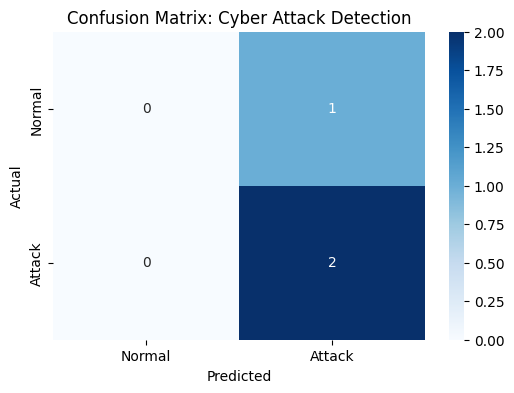


🔮 Testing with new data [Length=250, SpecialChars=35]: 🚨 ATTACK DETECTED!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# New imports for SVM and scaling
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LightGBM
import lightgbm as lgb

# 0. Preprocessing: Scale features (keeping for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. สร้างและฝึกสอนโมเดล (Training)
# Changed model to SVC (Support Vector Classifier)
model = SVC(random_state=42)
model.fit(X_train_scaled, y_train)

# 2. นำโมเดลไปทำนายผลกับข้อมูลทดสอบ (Testing)
y_pred = model.predict(X_test_scaled)

# 3. แสดงผลความแม่นยำ
print("📊 ผลการทำนายของโมเดล (Model Performance)")
print("-" * 30)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal (Human)', 'Attack (Bot)']))

# 4. วาด Confusion Matrix เพื่อดูว่าทายผิด/ถูกกี่รายการ
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Cyber Attack Detection')
plt.show()

# 5. ลองทำนายข้อมูลใหม่ (Real-time Prediction Simulation)
# สมมติมี Request ใหม่เข้ามา: URL ยาว 250 ตัวอักษร, มีอักขระพิเศษ 35 ตัว, ขนาด 2000 bytes
new_request = [[250, 35, 2000]]
# Scale the new request data before prediction
new_request_scaled = scaler.transform(new_request)
prediction = model.predict(new_request_scaled)
result = "🚨 ATTACK DETECTED!" if prediction[0] == 1 else "✅ NORMAL TRAFFIC"
print(f"\n🔮 Testing with new data [Length=250, SpecialChars=35]: {result}")